**상점 신용카드 매출 예측 대회**

# 문제 정의

## 경진대회 소개

**2016.6.1.부터 2019.2.28. 까지의 신용카드 매출 데이터를 가지고 2019.3.1.부터 2019.5.31.까지의 상점별 3개월 총매출을 예측**하는 경진대회


1회 대회에서 사용된 2016.8.1.~2018.7.31.의 데이터와 2회 대회에서 추가된 데이터 및 추가 상점 데이터를 학습시켜 정확한 신용카드 총매출을 예측해야 함

## 평가척도

평가하는 척도는 MAE임
- MAE란 실제값과 예측값의 차이에 절댓값을 취하고 평균값을 계산한 손실함수를 말함

$MAE=\frac{1}{m}\sum^n_{i=1}\left\vert y_i-y'_i\right\vert$

테스트 데이터의 50%로만 채점한 Public 점수와 대회 종료 후 나머지 50%를 추가로 채점함 Private 점수가 있음

## 대회 관련 사전 조사

1. **자영업자**는 상점을 운영하는 사람으로 많은 상황을 고려하게 하는 인물임. 상점의 매출은 상점이 운영되는 시기와 관련된 상황과 자영업자의 상황에 따라 움직인다는 점을 고려해야함
2. **카드사 직원**은 다양한 결제 방식을 떠올리게 해줌. 재결제하는 상황도 발생할 수 있음. 할부 결제를 정의할 필요성이 있음
3. **고객**은 가장 중요한 인물이자 다양한 상황을 발생시킴

## 문제 해결을 위한 접근 방식 소개

**데이터 살펴보기**
- 시계열(Time-series) 데이터가 제공됨

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")
os.chdir("./drive/MyDrive/All_in_kaggle/Chap4")
train = pd.read_csv('./data/funda_train.csv')
submission = pd.read_csv('./data/submission.csv')

In [ ]:
train.shape

(6556613, 9)

In [ ]:
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6556613 entries, 0 to 6556612
Data columns (total 9 columns):
 #   Column            Dtype  
---  ------            -----  
 0   store_id          int64  
 1   card_id           int64  
 2   card_company      object 
 3   transacted_date   object 
 4   transacted_time   object 
 5   installment_term  int64  
 6   region            object 
 7   type_of_business  object 
 8   amount            float64
dtypes: float64(1), int64(3), object(5)
memory usage: 450.2+ MB


|#|변수명|설명|
|---|---|---|
|1|store_id|상점의 고유 아이디|
|2|card_id|사용한 카드의 고유 아이디|
|3|card_company|비식별화된 카드 회사|
|4|transacted_date|거래 날짜|
|5|transacted_time|거래 시간(시:분)|
|6|installment_term|할부 개월 수(포인트 사용시 '60개월+실제 할부 개월'을 할부 개월 수에 기재함)|
|7|region|상점의 지역|
|8|type_of_business|상점의 업종|
|9|amount|매출액(단위는 원이 아님)|

**데이터의 노이즈**
- 결측값(NA, nan), 이상치(outlier), 빈칸으로 남겨진 데이터(unknown), 사람의 실수로 잘못 입력된 값, 익명화된 속성 등의 노이즈가 있음

In [ ]:
train[:5]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


지역(region)속성에 결측값이 존재하는 것을 알 수 있음
- 평균값 대치, 0으로 대치, 제거 등 다양한 방법으로 처리 가능

이상치가 존재하는 경우
- amount 변수에서 평균에서 크게 벗어나는 값이 존재함
- Max, Min을 확인하고 분석 과정에서 예측에 방해가 될 것 같은 이상치는 전처리 과정에서 정리하는 것이 좋음

In [ ]:
train[train['amount']<0]

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
41,0,40,a,2016-06-10,17:26,2,NaN,기타 미용업,-8571.428571
347,0,285,a,2016-08-04,17:52,0,NaN,기타 미용업,-1857.142857
731,0,473,g,2016-10-17,10:32,0,NaN,기타 미용업,-2000.000000
831,0,230,b,2016-11-03,15:36,0,NaN,기타 미용업,-85.714286
944,0,138,a,2016-11-28,13:21,0,NaN,기타 미용업,-57.142857
...,...,...,...,...,...,...,...,...,...
6556242,2136,4663626,b,2019-02-01,21:19,0,제주 제주시,기타 주점업,-13428.571429
6556448,2136,4663760,d,2019-02-15,00:46,0,제주 제주시,기타 주점업,-6928.571429
6556485,2136,4663779,b,2019-02-18,02:45,0,제주 제주시,기타 주점업,-5571.428571
6556489,2136,4663780,d,2019-02-18,21:43,0,제주 제주시,기타 주점업,-8571.428571


매출액(amount)에 음수 값이 존재함
- 음수 값은 환불을 나타내므로 이상치로 볼 수 있음

**분석 방향**
- 시계열 데이터 다루는 대회에서는 딥러닝 보다 트리 기반의 앙상블 모델이 더 좋은 성능을 냄
  - XGBoost와 LightGBM을 사용하는데 좋은 성능와 빠른 속도를 자랑함
- 시계열 모델을 사용한 가장 큰 이유는 시간의 흐름에 따라 발생된 데이터라는 점, 시간에 영향을 받는 관측치라는 점임
- 외부적으로 고려해야할 일들이 많이 있음
- 상점별로 개별적인 시계열 모델링을 진행할 것임


# 데이터 전처리

## 노이즈 제거

In [ ]:
# 5개의 행을 출력하는 코드
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
train = pd.read_csv('./data/funda_train.csv')
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

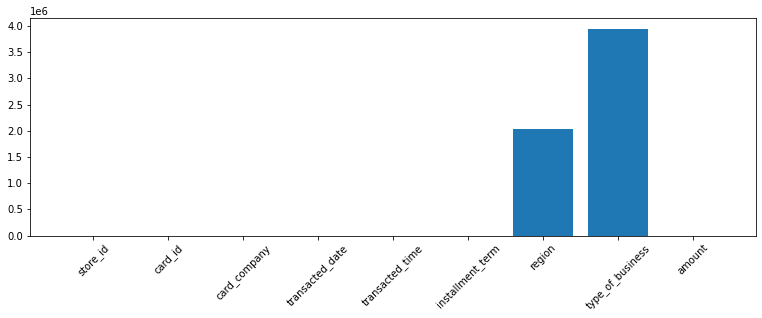

In [ ]:
plt.figure(figsize=(13,4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)

지역(region)와 업종(type_of_business) 속성에 결측치가 존재함
- 상점의 지역과 업종은 절반 이상이 결측치임
- 범주형 속성이고 대치할 방법도 없어 열전체를 제거하고 결과를 출력해보겠음

In [ ]:
train = train.drop(['region','type_of_business'],axis=1)
train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
0,0,0,b,2016-06-01,13:13,0,1857.142857
1,0,1,h,2016-06-01,18:12,0,857.142857
2,0,2,c,2016-06-01,18:52,0,2000.000000
3,0,3,a,2016-06-01,20:22,0,7857.142857
4,0,4,c,2016-06-02,11:06,0,2000.000000


<AxesSubplot:xlabel='amount'>

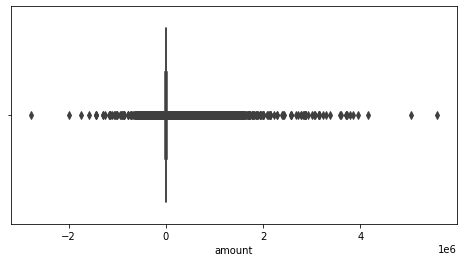

In [ ]:
#이상치 존재 여부를 확인하기 위해 box plot
plt.figure(figsize=(8, 4))
sns.boxplot(train['amount'])

매출액(amount) 변수에 음수가 존재함
- 환불이 발생한 것이고 상점 매출액을 예측할 때 방해가 되는 노이즈임
- 매출액이 0 미만인 행을 출력함

In [ ]:
train[train['amount']<0].head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount
41,0,40,a,2016-06-10,17:26,2,-8571.428571
347,0,285,a,2016-08-04,17:52,0,-1857.142857
731,0,473,g,2016-10-17,10:32,0,-2000.000000
831,0,230,b,2016-11-03,15:36,0,-85.714286
944,0,138,a,2016-11-28,13:21,0,-57.142857


노이즈 제거 기준
- 환불 발생 시간 이전의 거래 내역 중 음수 매출액의 절댓값과 같은 행은 제거함
- 환불 발생일과 환불 발생 시간 이전 데이터 중에서 카드 아이디가 같고 음수 매출액의 절댓값과 양수 매출액이 같은 거래 중 최근 거래를 찾아서 해당 인덱스를 제거함

In [ ]:
#거래일과 거래시간을 합친 변수를 생성
train['datetime'] = pd.to_datetime(train.transacted_date + " " + train.transacted_time, format="%Y-%m-%d %H:%M:%S")
##환불 거래를 제거하는 함수를 정의함
def remove_refund(df):
  refund = df[df['amount']<0] # 매출액 음숫값 데이터를 추출함
  non_refund = df[df['amount']>0] # 매출액 양숫값 데이터를 추출함
  removed_data = pd.DataFrame()

  for i in tqdm(df.store_id.unique()):
    # 매출액이 양숫값인 데이터를 상점별로 나눔
    divided_data = non_refund[non_refund['store_id']==i]
    # 매출액이 음숫값인 데이터를 상점별로 나눔
    divided_data2 = refund[refund['store_id']==i]

    for neg in divided_data2.to_records()[:]: #환불 데이터를 차례대로 검사함
      refund_store = neg['store_id']
      refund_id = neg['card_id'] # 환불 카드 아이디를 추출함
      refund_datetime = neg['datetime'] # 환불 시간을 추출함
      refund_amount = abs(neg['amount']) # 매출 음숫값의 절댓값을 구함

      # 환불 시간 이전의 데이터 중 카드 아이디와 환불액이 같은
      # 후보 리스트를 뽑음
      refund_pay_list = divided_data[divided_data['datetime']<refund_datetime]
      refund_pay_list = refund_pay_list[refund_pay_list['card_id']==refund_id]
      refund_pay_list = refund_pay_list[refund_pay_list['amount']==refund_amount]

      # 후보 리스트가 있으면 카드 아이디, 환불액 같으면서 가장 최근 시간을 제거함
      if len(refund_pay_list) != 0:
        # 가장 최근 시간을 구함
        refund_datetime = max(refund_pay_list['datetime'])
        # 가장 최근시간
        noise_list = divided_data[divided_data['datetime']==refund_datetime]
        # 환불 카드 아이디
        noise_list = noise_list[noise_list['card_id']==refund_id]
        # 환불액
        noise_list = noise_list[noise_list['amount']==refund_amount]
        # 인덱스를 통해 제거
        divided_data = divided_data.drop(index=noise_list.index)

    
    # 제거한 데이터를 데이터프레임에 추가함
    removed_data = pd.concat([removed_data,divided_data], axis=0)
    
  return removed_data

  0%|          | 0/1967 [00:00<?, ?it/s]

<AxesSubplot:xlabel='amount'>

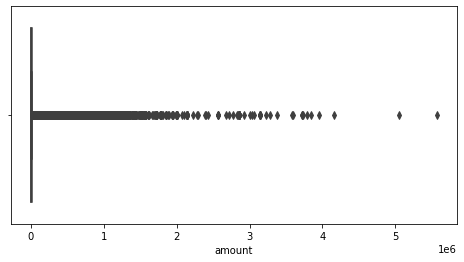

In [ ]:
## 환불 거래 제거 함수를 통해 환불 거래 제거
positive_data = remove_refund(train)
plt.figure(figsize=(8, 4))
sns.boxplot(positive_data['amount'])

## 다운 샘플링
- 시계열 데이터에서 시간 간격을 넓게 재조정해 데이터 샘플 수를 줄이는 것을 말함
- 향후 3개월 동안 상점 매출의 총합을 구하는 것이 문제임
- 예측 구간을 작게 해서 불확실성을 줄여야함 

In [ ]:
positive_data.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00


In [ ]:
positive_data.to_csv('./data/positive_data.csv',index=False)

본 대회의 문제는 미래 3개월 매출액의 총합임
- 3개월은 일 단위로 계산했을 때 약 90일이고 시간 단위로 계산했을 때 2,160 시간임
- 현재 데이터는 분 단위로 기록돼 있고 예측할 구간이 많다는 단점이 있음
- 시계열 모델은 예측 구간이 많아지면 불확실성이 커져 정확도가 떨어짐


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

positive_data = pd.read_csv('./data/positive_data.csv')
positive_data

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,amount,datetime
0,0,0,b,2016-06-01,13:13,0,1857.142857,2016-06-01 13:13:00
1,0,1,h,2016-06-01,18:12,0,857.142857,2016-06-01 18:12:00
2,0,2,c,2016-06-01,18:52,0,2000.000000,2016-06-01 18:52:00
3,0,3,a,2016-06-01,20:22,0,7857.142857,2016-06-01 20:22:00
4,0,4,c,2016-06-02,11:06,0,2000.000000,2016-06-02 11:06:00
...,...,...,...,...,...,...,...,...
6440879,2136,4663855,d,2019-02-28,23:20,0,4500.000000,2019-02-28 23:20:00
6440880,2136,4663855,d,2019-02-28,23:24,0,4142.857143,2019-02-28 23:24:00
6440881,2136,4663489,a,2019-02-28,23:24,0,4500.000000,2019-02-28 23:24:00
6440882,2136,4663856,d,2019-02-28,23:27,0,571.428571,2019-02-28 23:27:00


In [4]:
## 월 단위 다운 샘플링 함수 정의
def month_resampling(df):
  new_data = pd.DataFrame()
  # 년도와 월을 합친 변수를 생성함
  df['year_month'] = df['transacted_date'].str.slice(stop=7)
  # 데이터의 전체 기간을 추출함
  year_month = df['year_month'].drop_duplicates()
  # 상점 아이디별로 월 단위 매출액 총합을 구함
  downsampling_data = df.groupby(['store_id','year_month']).amount.sum()
  downsampling_data = pd.DataFrame(downsampling_data)
  downsampling_data = downsampling_data.reset_index(drop=False, inplace=False)

  for i in tqdm(df.store_id.unique()):
    # 상점별로 데이터를 처리함
    store = downsampling_data[downsampling_data['store_id']==i]
    # 각 상점의 처음 매출이 발생한 월을 구함
    start_time = min(store['year_month'])
    # 모든 상점을 전체 기간 데이터로 만듦
    store = store.merge(year_month,how='outer')
    # 데이터를 시간순으로 정렬함
    store = store.sort_values(by=['year_month'], axis=0, ascending=True)
    # 매출이 발생하지 않는 월은 2로 채움
    store['amount'] = store['amount'].fillna(2)
    # 상점 아이디 결측치를 채움
    store['store_id'] = store['store_id'].fillna(i)
    # 처음 매출이 발생한 월 이후만 뽑음
    store = store[store['year_month'] >= start_time]

    new_data = pd.concat([new_data, store],axis=0)
  
  return new_data
  

각 상점의 다운 샘플링을 진행할 때 매출이 발생하지 않았던 월은 2로 대치함
- 0으로 대치하지 않은 이유는 이후 시계열 데이터의 진동 폭을 안정화하기 위해 **로그 정규화**를 진행하기 때문임
- 1이하 값은 로그 정규화를 할 때 음수 또는 무한대가 나오기 때문에 2로 대치함

In [5]:
# 환불 제거 데이터를 월 단위로 다운 샘플링
resampling_data = month_resampling(positive_data)
resampling_data['store_id'] = resampling_data['store_id'].astype(int)
resampling_data

  0%|          | 0/1967 [00:00<?, ?it/s]

,store_id,year_month,amount
0,0,2016-06,7.470000e+05
1,0,2016-07,1.005000e+06
2,0,2016-08,8.734286e+05
3,0,2016-09,8.978571e+05
4,0,2016-10,8.354286e+05
...,...,...,...
17,2136,2018-10,2.026857e+06
18,2136,2018-11,2.148929e+06
19,2136,2018-12,2.448500e+06
20,2136,2019-01,1.879500e+06


카드 결제 이력 데이터에 대해 월 단위로 시간 간격을 재조정한 결과를 확인할 수 있음
- 미래 3개월의 매출을 예측할 때 예측 구간이 3개로 줄었음
- 다운 샘플링은 예측 구간을 최소화해 불확실성을 줄여줌


## 날짜 지정 범위 생성과 시리즈 객체 변환

시계열 데이터 분석을 위해서는 데이터프레임을 시리즈 객체로 변환해야함
- 시계열 데이터의 **정상성(stationarity)**을 확인하기 위한 단위근 검정과 시계열 모델 구축 과정에서 시리즈 객체를 사용함
- 시리즈 객체로 변환하기 전에 인덱스를 시간 변수로 정의함
- 시간 변수의 날짜 지정 범위를 생성해야함

In [6]:
## 데이터 타입을 출력
print(type(resampling_data))

<class 'pandas.core.frame.DataFrame'>


In [7]:
# 데이터프레임을 Series로 변환하는 함수
def time_series(df, i):
  # 상점별로 데이터를 뽑음
  store = df[df['store_id']==i]
  ## 날짜 지정 범위는 영업 시작 월부터 2019년 3월 전까지 영업 마감일 기준
  index = pd.date_range(min(store['year_month']), '2019-03', freq='BM')
  ## 시리즈 객체로 변환
  ts = pd.Series(store['amount'].values, index=index)
  return ts

In [8]:
# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)
store_0

2016-06-30    7.470000e+05
2016-07-29    1.005000e+06
2016-08-31    8.734286e+05
2016-09-30    8.978571e+05
2016-10-31    8.354286e+05
2016-11-30    6.971429e+05
2016-12-30    7.618571e+05
2017-01-31    5.856429e+05
2017-02-28    7.940000e+05
2017-03-31    7.202571e+05
2017-04-28    6.852857e+05
2017-05-31    7.444286e+05
2017-06-30    6.820000e+05
2017-07-31    7.465714e+05
2017-08-31    7.490000e+05
2017-09-29    8.408571e+05
2017-10-31    6.005714e+05
2017-11-30    6.308571e+05
2017-12-29    8.127143e+05
2018-01-31    6.431429e+05
2018-02-28    6.852857e+05
2018-03-30    8.484286e+05
2018-04-30    6.361429e+05
2018-05-31    6.864286e+05
2018-06-29    7.072857e+05
2018-07-31    7.587143e+05
2018-08-31    6.818571e+05
2018-09-28    6.552857e+05
2018-10-31    7.390000e+05
2018-11-30    6.760000e+05
2018-12-31    8.745714e+05
2019-01-31    6.828571e+05
2019-02-28    5.152857e+05
Freq: BM, dtype: float64

In [9]:
## 데이터 타입을 출력
store_1 = time_series(resampling_data, 1)
print(type(store_1))

<class 'pandas.core.series.Series'>


<AxesSubplot:>

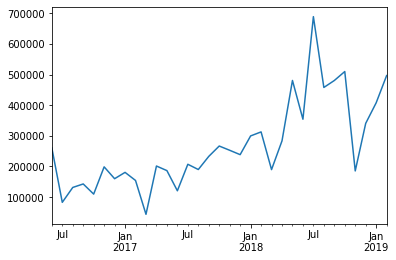

In [10]:
# 상점 아이디가 2번인 데이터를 시리즈 객체로 변환
store_2 = time_series(resampling_data, 2)
store_2.plot()

매출액의 변동이 있는 것을 알 수 있음
- 2017년은 큰 변화가 아닌 작은 변동 폭을 보여줌
- 2018년 3월 이후부터 매출액의 상승이 커지다가 2018년 7월에 매출액이 최고액을 기록함
- 그 이후 매출액이 급격히 감소함
---
2017년 데이터는 작은 변동 폭을 기록하고 있는데 이러한 변화는 큰 트렌드가 아니기 때문에 로그 정규화를 하면 변동이 안정화되어 더 큰 트렌드를 파악할 수 있음
- 시계열 모델 구축에는 매출액의 변동 계수를 고려해서 작은 변동을 안정화하는 로그 정규화를 진행할 예정임


# 탐색적 데이터 분석

## 상점별 매출 특성

**계절성이 있는 상점**
- 성수기 황금연휴가 있는 시기임
- 특정 계절을 중심으로 장사하거나 특정 계절을 중심으로 장사하지 않는 특징을 지닌 상점이 존재하는지 알아봐야함

In [11]:
# 상점 아이디가 257번인 데이터를 시리즈 객체로 데이터 출력
store_257 = time_series(resampling_data, 257)
store_257

2016-06-30    4.891857e+05
2016-07-29    1.615080e+06
2016-08-31    1.648829e+06
2016-09-30    3.369143e+05
2016-10-31    8.491427e+05
2016-11-30    2.000000e+00
2016-12-30    2.000000e+00
2017-01-31    2.000000e+00
2017-02-28    2.000000e+00
2017-03-31    2.000000e+00
2017-04-28    3.979443e+04
2017-05-31    1.714429e+05
2017-06-30    5.481317e+05
2017-07-31    7.359286e+05
2017-08-31    7.909700e+05
2017-09-29    6.191429e+04
2017-10-31    1.027143e+06
2017-11-30    2.000000e+00
2017-12-29    2.000000e+00
2018-01-31    2.000000e+00
2018-02-28    2.000000e+00
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.512714e+05
2018-06-29    4.825286e+05
2018-07-31    9.304677e+05
2018-08-31    1.654827e+06
2018-09-28    2.767857e+05
2018-10-31    2.000000e+00
2018-11-30    2.000000e+00
2018-12-31    2.000000e+00
2019-01-31    2.000000e+00
2019-02-28    2.000000e+00
Freq: BM, dtype: float64

- 데이터 전처리 과정에서 매출이 발생하지 않았던 월은 전부 2로 대치했으므로 매출액이 2인 월은 매출이 발생하지 않은 월임

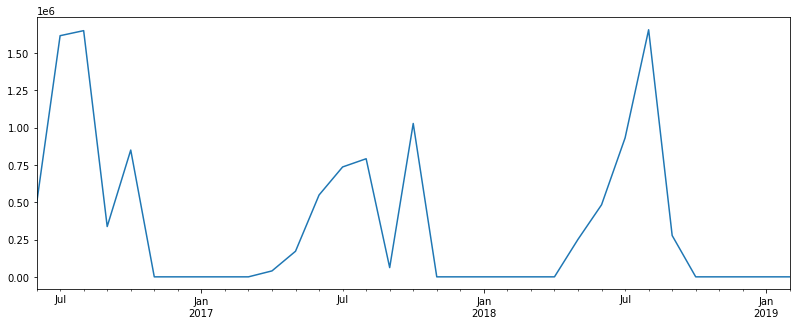

In [12]:
# 시계열 그래프 그리기
store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5,5)

여름 시즌에 많은 매출이 발생한 것을 알 수 있음

In [13]:
# 상점 아이디가 2096번인 데이터를 시리즈 객체로 데이터 출력
store_2096 = time_series(resampling_data, 2096)
store_2096

2016-06-30    1.434286e+02
2016-07-29    5.075429e+04
2016-08-31    9.219543e+05
2016-09-30    4.720786e+05
2016-10-31    5.145714e+05
2016-11-30    1.494286e+05
2016-12-30    1.071686e+06
2017-01-31    1.602857e+06
2017-02-28    1.332143e+06
2017-03-31    2.432143e+05
2017-04-28    3.903143e+06
2017-05-31    1.729500e+06
2017-06-30    4.280214e+06
2017-07-31    1.775714e+06
2017-08-31    7.430000e+05
2017-09-29    1.415714e+06
2017-10-31    1.180714e+06
2017-11-30    4.640000e+05
2017-12-29    1.389729e+06
2018-01-31    2.000000e+00
2018-02-28    8.285714e+05
2018-03-30    7.857143e+05
2018-04-30    6.670429e+06
2018-05-31    1.837286e+05
2018-06-29    3.285858e+06
2018-07-31    9.575714e+05
2018-08-31    3.693057e+06
2018-09-28    1.793886e+06
2018-10-31    4.717743e+06
2018-11-30    7.593600e+06
2018-12-31    1.428571e+06
2019-01-31    4.285714e+05
2019-02-28    1.428571e+06
Freq: BM, dtype: float64

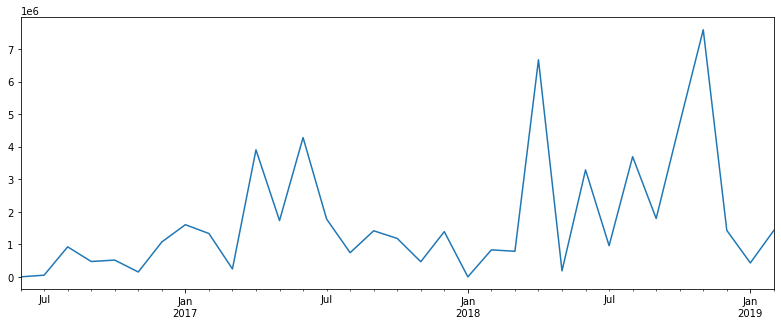

In [14]:
# 상점 아이디가 2096번인 상점의 시계열 그래프
store_plot_2096 = store_2096.plot()
fig = store_plot_2096.get_figure()
fig.set_size_inches(13.5,5)

2096번 상점은 겨울 시즌(1~3월)에 낮은 매출액을 기록하다가 4월 매출액이 급상승하는 패턴을 보여줌


**계절성 있는 상점의 특징**

|상점 아이디|특징|
|---|---|
|257|겨울 시즌(11 ~ 3월)에는 매출액이 낮고 여름 시즌(7 ~ 8월)에 많은 매출을 기록|
|2096|겨울 시즌(1 ~ 3월)에는 매출액이 낮고 4월에 매출액이 상승하는 패턴을 보임|

**추세가 있는 상점**
- 매출액이 꾸준히 증가하는 상점 또는 매출액이 꾸준히 감소하는 상점을 뜻함
- 매출액이 급감하는 상점도 있음

In [15]:
# 상점 아이디가 335번인 상점의 시계열 그래프
store_335 = time_series(resampling_data, 335)

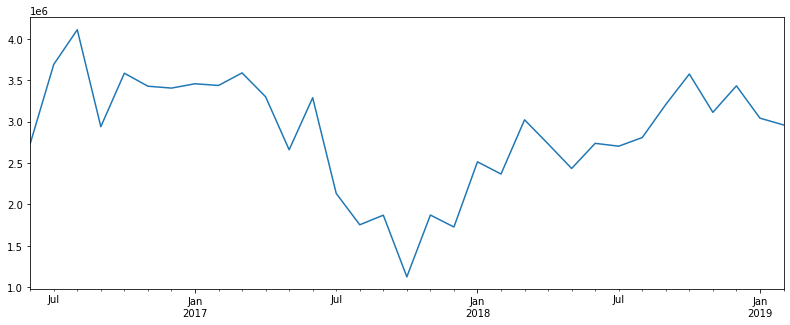

In [16]:
store_plot_335 = store_335.plot()
fig = store_plot_335.get_figure()
fig.set_size_inches(13.5,5)

매출액 증감 등의 변동은 매월 있음을 알 수 있음
- 월 단위의 작은 변동보다는 기간을 1년 단위로 해서 추세를 파악할 필요가 있음

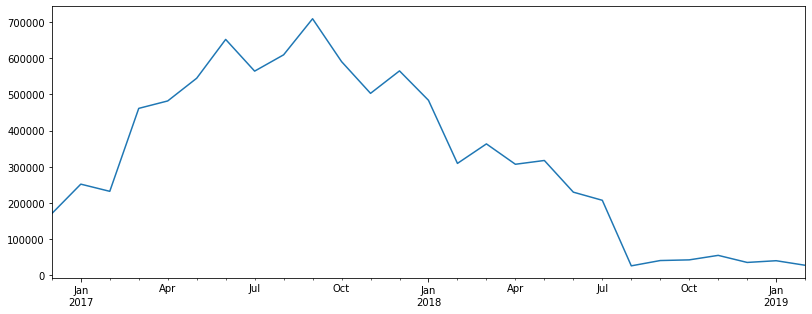

In [17]:
# 상점 아이디가 510번인 상점의 시계열 그래프
store_510 = time_series(resampling_data, 510)
store_plot_510 = store_510.plot()
fig = store_plot_510.get_figure()
fig.set_size_inches(13.5,5)

**추세가 있는 상점의 특징**

|상점 아이디|특징|
|---|---|
|335|2016년 6월 ~ 2017년 10월 감소 추세, 2017년 11월 ~ 2019년 2월 증가 추세|
|510|2016년 12월 ~ 2017년 8월 증가 추세, 2017년 9월 이후 감소 추세|

**휴업 중인 상점**
- 몇 개월 동안 매출이 발생하지 않은 상점

In [18]:
# 상점 아이디가 111번인 데이터를 시리즈 객체로 데이터 출력
store_111 = time_series(resampling_data, 111)
store_111

2016-06-30    814571.428571
2016-07-29    391142.857143
2016-08-31     13071.428571
2016-09-30    495714.285714
2016-10-31    182714.285714
2016-11-30    178571.428571
2016-12-30     43004.285714
2017-01-31         2.000000
2017-02-28      5428.571429
2017-03-31     24714.285714
2017-04-28    108000.000000
2017-05-31    469285.714286
2017-06-30    137571.428571
2017-07-31    216285.714286
2017-08-31     77001.428571
2017-09-29     78005.714286
2017-10-31         2.000000
2017-11-30         2.000000
2017-12-29         2.000000
2018-01-31      1428.571429
2018-02-28    310072.857143
2018-03-30    259214.285714
2018-04-30    225857.142857
2018-05-31    115144.285714
2018-06-29         2.000000
2018-07-31    123285.714286
2018-08-31         2.000000
2018-09-28     83000.000000
2018-10-31         2.000000
2018-11-30         2.000000
2018-12-31         2.000000
2019-01-31         2.000000
2019-02-28         2.000000
Freq: BM, dtype: float64

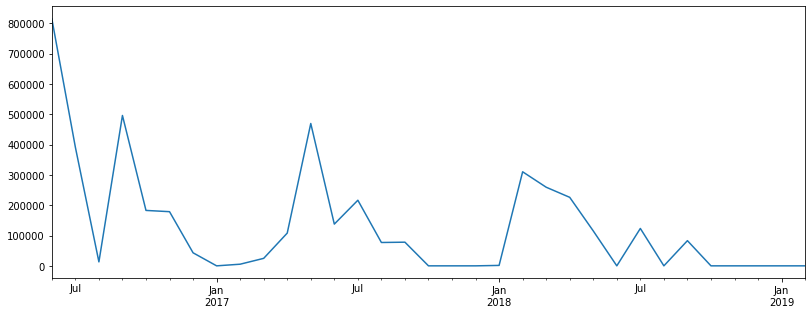

In [19]:
# 상점 아이디가 111번인 상점의 시계열 그래프
store_plot_111 = store_111.plot()
fig = store_plot_111.get_figure()
fig.set_size_inches(13.5, 5)

In [20]:
# 상점 아이디가 279번인 데이터를 시리즈 객체로 데이터 출력
store_279 = time_series(resampling_data, 279)
store_279

2016-06-30    4.488571e+05
2016-07-29    1.163429e+06
2016-08-31    1.372857e+06
2016-09-30    3.150000e+05
2016-10-31    8.748571e+05
2016-11-30    3.142857e+05
2016-12-30    5.828571e+05
2017-01-31    3.214286e+04
2017-02-28    2.000000e+00
2017-03-31    4.957149e+05
2017-04-28    5.940000e+05
2017-05-31    1.041143e+06
2017-06-30    8.611429e+05
2017-07-31    6.171429e+05
2017-08-31    4.384286e+05
2017-09-29    1.596972e+06
2017-10-31    3.294286e+05
2017-11-30    2.241429e+05
2017-12-29    2.785714e+05
2018-01-31    4.018571e+05
2018-02-28    1.282857e+05
2018-03-30    2.000000e+00
2018-04-30    2.000000e+00
2018-05-31    2.000000e+00
2018-06-29    2.000000e+00
2018-07-31    2.000000e+00
2018-08-31    2.000000e+00
2018-09-28    2.000000e+00
2018-10-31    2.000000e+00
2018-11-30    2.101429e+05
2018-12-31    2.191571e+05
2019-01-31    1.779286e+05
2019-02-28    5.157143e+04
Freq: BM, dtype: float64

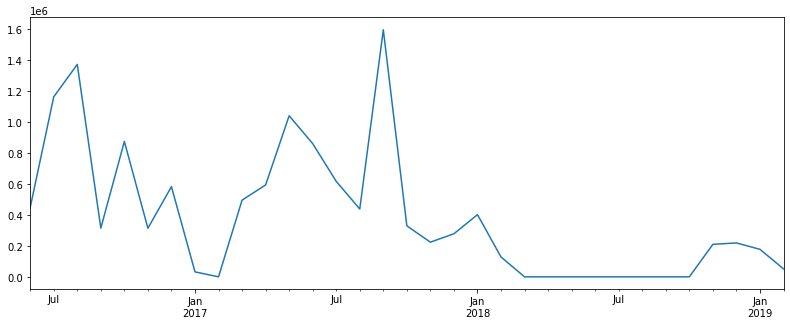

In [21]:
# 상점 아이디가 279번인 상점의 시계열 그래프
store_plot_279 = store_279.plot()
fig = store_plot_279.get_figure()
fig.set_size_inches(13.5, 5)

장기 휴업, 폐업으로 예상됨

**휴업 중인 상점 특징 정리**

|상점 아이디|특징|
|---|---|
|111|2017년 10월 ~ 2017년 12월 휴업, 2019년 10월 이후 휴업 상태|
|279|2018년 3월 ~ 2018년 10월 휴업, 2019년 11월 영업 재개, 2019년 2월 매출 감소|

## 시계열 데이터의 정상성

추세나 계절성이 없는 시계열 데이터를 의미함
- 시간의 변동에 따라 평균과 분산이 일정하다는 뜻
---
정상성을 판단하기 위해 ADF-Test를 사용하고 **차분(differencing)**을 통해 비정상 시계열을 정상 시계열로 변환하는 작업 진행



**ADF-Test**
- Augmented Dickey-Fuller-Test의 약자임
- 시계열 데이터가 정상성을 가지는지를 판단할 때 사용하며 회귀 분석의 결과로 나온 계수를 검정 통계량으로 사용함
- ADF-Test로 정상성을 검정하고 정상성을 가지지 않으면 차분을 통해 평균을 일정하게 만들어줌
  - 차분은 비정상 시계열을 평균이 일정한 정상 시계열로 바꾸는 기법임
  

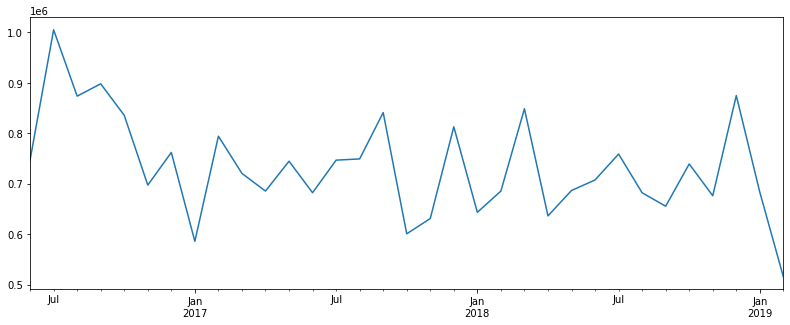

In [22]:
# 상점 아이디가 0번인 상점의 시계열 그래프
store_0 = time_series(resampling_data, 0)
store_plot_0 = store_0.plot()
fig = store_plot_0.get_figure()
fig.set_size_inches(13.5, 5)

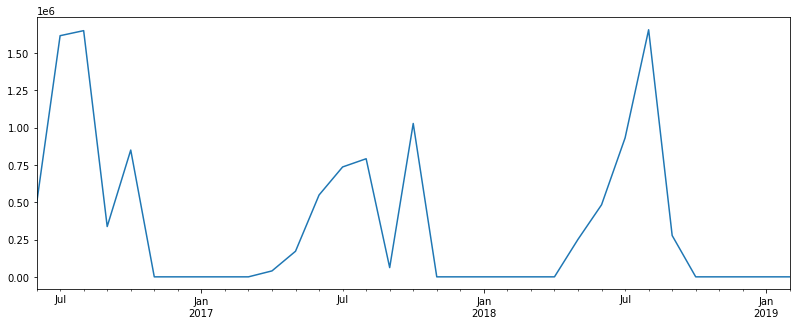

In [23]:
# 상점 아이디가 257번인 상점의 시계열 그래프
store_257 = time_series(resampling_data, 257)
store_plot_257 = store_257.plot()
fig = store_plot_257.get_figure()
fig.set_size_inches(13.5, 5)

0번 상점은 평균과 분산이 일정한 것에 비해 257번 상점은 계절성을 띠고 평균과 분산의 변동 폭이 큰 것을 알 수 있음

ADF-Test 시행전 가설을 설정
1. 귀무 가설: 시계열 자료가 정상 시계열이 아니다.
2. 대립 가설: 시계열 자료가 정상성을 만족한다.

In [24]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
# pmdarima 패키지에 있는 ADFTest 클래스를 임포트
from pmdarima.arima import ADFTest

# 상점 아이디가 0번인 데이터를 시리즈 객체로 변환
store_0 = time_series(resampling_data, 0)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_0)
print('p_val : %f, should_diff : %s' %(p_val, should_diff))

p_val : 0.021842, should_diff : False


In [26]:
# 상점 아이디가 257번인 데이터를 시리즈 객체로 변환
store_257 = time_series(resampling_data, 257)
# ADF-Test 시행
p_val, should_diff = ADFTest().should_diff(store_257)
print('p_val : %f, should_diff : %s' %(p_val, should_diff))

p_val : 0.080239, should_diff : True


ADFTest 클래스의 생성자 매개변수 alpha는 가설 검증을 할 때 p-value 값의 기준점을 의미함
- ADFTest 클래스의 should_diff() 함수는 인자로 시리즈 객체를 받고 p-value 값과 차분이 필요한지를 True 또는 False로 반환함
---
p-value 값이 기준점인 0.05보다 낮으면 대립 가설이, 높으면 귀무 가설이 채택됨
- 257번 아이디는 차분이 필요함을 볼 수 있음

**ADF-Test 결과**

|상점 아이디|p-value|정상시계열|차분(should_diff)|
|---|---|---|---|
|0|0.022488|O|필요 없음|
|257|0.093614|X|필요함|

  0%|          | 0/1967 [00:00<?, ?it/s]

<AxesSubplot:>

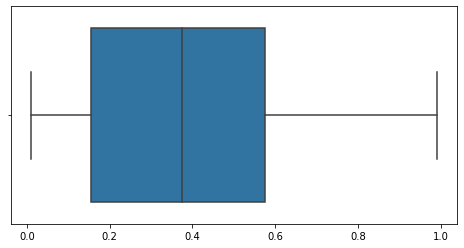

In [27]:
## ARIMA 모델의 차분 여부를 결정하기 위한 단위근 검정
def adf_test(y):
  return ADFTest().should_diff(y)[0]

## 전체 상점 adf_test p-value 값을 리스트에 저장해 boxplot
adf_p = []
count = 0
skipped = []
for i in tqdm(resampling_data['store_id'].unique()):
  ts = time_series(resampling_data, i)
  try:
    p_val = adf_test(ts)
    if p_val < 0.05:
      count += 1
    adf_p.append(p_val)
  except:
    skipped.append(i)

plt.figure(figsize=(8 ,4))
sns.boxplot(adf_p)

In [28]:
# p-value가 0.05보다 작은 상점의 개수
print(count)

268


In [29]:
# ADF-Test 오류 상점 개수
if skipped:
  print(f"WarningCount: {len(skipped)},store_id_list:{skipped}")

In [30]:
skipped

[]

오류 발생은 없어 보임